In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [3]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn.n_cycles = 39
rxn.compile()

In [4]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")

In [5]:
cmax = 40

file = data_pth / "JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx"

JG034 = (
    can.test.QuantStudio(file, "JG034")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

data = (
    JG034.reactions.data[
        (JG034.reactions.data["Cycle"] <= cmax)
        & (JG034.reactions.data.Target.str.contains("GC55"))
    ]
    .groupby(["lg10_Copies", "Target", "Cycle"])[["Fluorescence", "Reaction"]]
    .first()
    .reset_index()
)

In [37]:
def plot_data(ax=None, **kwargs):
    ax = plt.gca() if ax is None else ax

    g = sns.lineplot(
        data=data,
        x="Cycle",
        y="Fluorescence",
        units="Reaction",
        estimator=None,
        hue="lg10_Copies",
        palette="ch:0",
        # legend=False,
        ax=ax,
        **kwargs
    )

    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(1.0, -0.85),
        ncol=7,
        title=r"log$_{10}$ Copies",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handletextpad = 0.5,
        columnspacing = 1
    )

In [38]:
def plot_simulations(ax=None, palette="coolwarm_r", **kwargs):
    ax = plt.gca() if ax is None else ax

    WT_data = ps[(ps.Target == "S044.19") & (ps.Metric == "mean")]
    WT_rate = WT_data["r"].mean()
    WT_m = WT_data["m"].mean()
    WT_K = WT_data.groupby("lg10_Copies")["K"].mean()
    WT_F0_lg = WT_data.groupby("lg10_Copies")["F0_lg"].mean()

    lg_Q = (
        (WT_F0_lg - np.log10(WT_K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    WT_lg_Q = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))

    rxn.n_cycles = 40
    c = np.arange(1, 41)
    rxn.oligo("WT").rate = WT_rate
    copies = np.arange(2, 9)
    palette = sns.color_palette(palette, len(copies))
    norm = rxn.norm.copies

    comp_data = ps[(ps.Target == "S044.6") & (ps.Metric == "mean")]
    r = comp_data["r"].mean()
    m = comp_data["m"].mean()
    K = comp_data.groupby("lg10_Copies")["K"].mean()
    F0_lg = comp_data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (F0_lg - np.log10(K)).mean() - (7 + 5 - np.log10(6.022e23))

    rxn.oligo("REF").rate = r
    rxn.oligo("REF").copies = 10**lg_Q

    for strand, drift in zip(rxn.strands, [WT_m, WT_m, m, m]):
        strand.drift = drift

    rxn.oligo("WT").copies = 10 ** WT_lg_Q(8)
    solution = rxn.solve()[:40, -2:] / norm
    norm *= solution[-1, 0]

    for i, WT_copies in enumerate(copies):
        rxn.oligo("WT").copies = 10 ** WT_lg_Q(WT_copies)
        solution = rxn.solve()[:40, -2:] / norm
        for j in range(2):
            mult = [+1, -1][j]
            if j == 1:
                ax.plot(
                    rxn.cycles[:-1] + 1,
                    mult * solution[:, j],
                    color=palette[i],
                    label=WT_copies - 5,
                    **kwargs
                )
                # ax.legend(loc='center left')
            else:
                ax.plot(
                    rxn.cycles[:-1] + 1,
                    mult * solution[:, j],
                    color=palette[i],
                    **kwargs
                )

Saving fig_2A__stone_salmon in /home/john/projects/can-manuscript/fig_2__glass_rattlesnake/graphics: [.svg] [.png] done


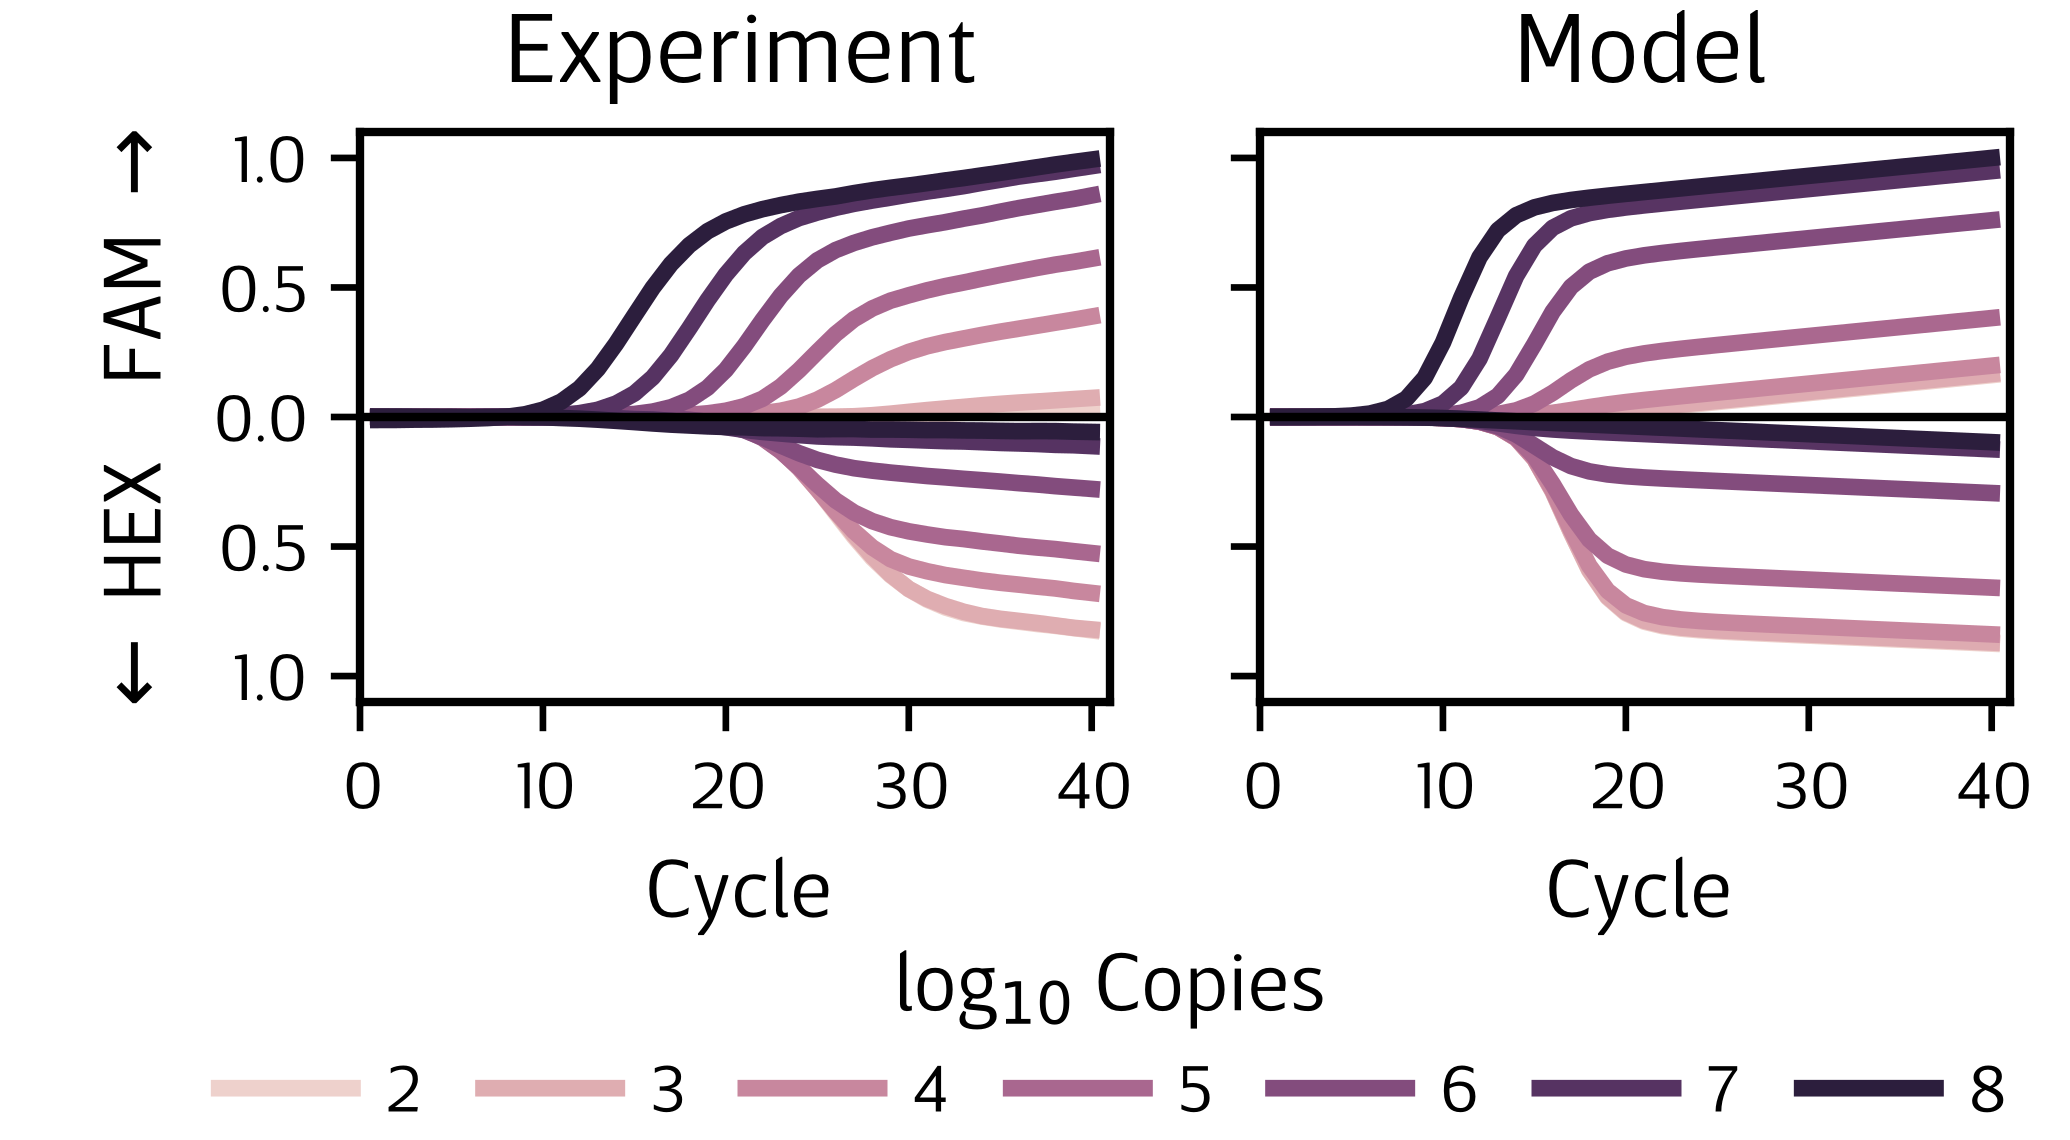

In [39]:
width = 3.45
height = 1.65+0.25
figsize = (width, height)
spotsize = 8**2
linewidth = 2
ticklabelsize = 8
labelsize = 10
titlesize = labelsize + 2

fig, axs = plt.subplots(1, 2, figsize=(width, height), sharex=True, sharey=True)

plot_data(ax=axs[0], linewidth=linewidth)
plot_simulations(ax=axs[1], linewidth=linewidth, palette="ch:0")

for ax in axs:
    ax.axhline(0, color="k", linewidth=1)
    ax.set_xlabel("Cycle", fontsize=labelsize)
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xlim([0, 41])
    ax.set_ylim([-1.1, 1.1])
    ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])
    ax.tick_params(axis="both", labelsize=ticklabelsize)
    plt.setp(ax.spines.values(), linewidth=1)

axs[0].set_ylabel(r"$\leftarrow$ HEX    FAM $\rightarrow$", fontsize=labelsize)
axs[0].set_title("Experiment", fontsize=titlesize)
axs[1].set_title("Model", fontsize=titlesize)

mar_l = 0.6
mar_r = 0.1
mar_t = 0.22
mar_b = 0.48+0.25

plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

savefig(fig, alias="stone_salmon", display_width_inches=1)